### Asunnon hinnan ennustaminen Oslossa

Ladataan kirjastot.
Haetaan data insideairbnb.com -palvelusta, valitaan Oslo.
Siivotaan dataa.
Tutkitaan scatterplot kuvalla riippuvuuksia
Testataan usealla koneoppimisalgoritmilla ennustamista
Kesken

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

Haetaan Oslon datasta 12 mielenkiintoista saraketta ja luetaan ne dataframeen gzip muodossa. Lisäksi sama kirjoitetaan tiedostoon data.csv jotta tietoja voidaan tarkastella muissa sovelluksissa. Lopuksi tulostetaan rivien ja sarakkeiden määrä.

In [2]:
listings_file = 'http://data.insideairbnb.com/norway/oslo/oslo/2019-09-28/data/listings.csv.gz'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(listings_file, compression='gzip', usecols=cols)
df.to_csv('data.csv')

len(df.index)
df.shape

(8577, 12)

Tutkitaan miltä data näyttää.

In [3]:
#df = df.rename_axis(['index'])
df.head()

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,Frogner,Entire home/apt,3,2.0,3.0,"$1,925.00",28,37,97.0,t,moderate,0.50
1,Frogner,Private room,3,1.0,1.0,$381.00,0,36,97.0,t,strict_14_with_grace_period,0.70
2,Frogner,Private room,1,1.0,2.0,$472.00,0,47,96.0,f,strict_14_with_grace_period,0.44
3,Sagene,Entire home/apt,3,1.0,1.0,$999.00,28,7,94.0,f,moderate,0.07
4,Gamle Oslo,Private room,3,1.0,2.0,$499.00,0,48,95.0,f,moderate,0.46


In [4]:
list(df)

['neighbourhood_cleansed',
 'room_type',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'availability_30',
 'number_of_reviews',
 'review_scores_rating',
 'instant_bookable',
 'cancellation_policy',
 'reviews_per_month']

Siivotaan dollarin merkki hinta sarakkeesta, mutta objekti on viellä väärin.

In [5]:
df = pd.read_csv('data.csv', low_memory=False, converters={'price': lambda s: (s.replace('$', ''))})
df.price.head(5)

0    1,925.00
1      381.00
2      472.00
3      999.00
4      499.00
Name: price, dtype: object

Siivotaan sekä pilkku että tuhansien erottimena ja muunnetaan kentän tyypiksi float.

In [6]:
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)
#df.price.sort_values(ascending=False).head(100)

0    1925.0
1     381.0
2     472.0
3     999.0
4     499.0
Name: price, dtype: float64

In [7]:
df.shape

(8577, 13)

Asuntojen määrä kaupunginosittain

In [8]:
df.neighbourhood_cleansed.value_counts().head()

Grünerløkka       1856
Gamle Oslo        1518
Frogner           1440
St. Hanshaugen    1129
Sagene             944
Name: neighbourhood_cleansed, dtype: int64

Sama graafisesti kaupunginosat järjestyksessä.
Koodista katsoen counter -luokan avulla dictionaryn, joka muunnetaan from_dict metodilla data frame, pandas toteuttaa dataframen piirtämisen suoraan plot metodilla. Tyyliä säädetään plt.rcParams parametri säädön avulla.

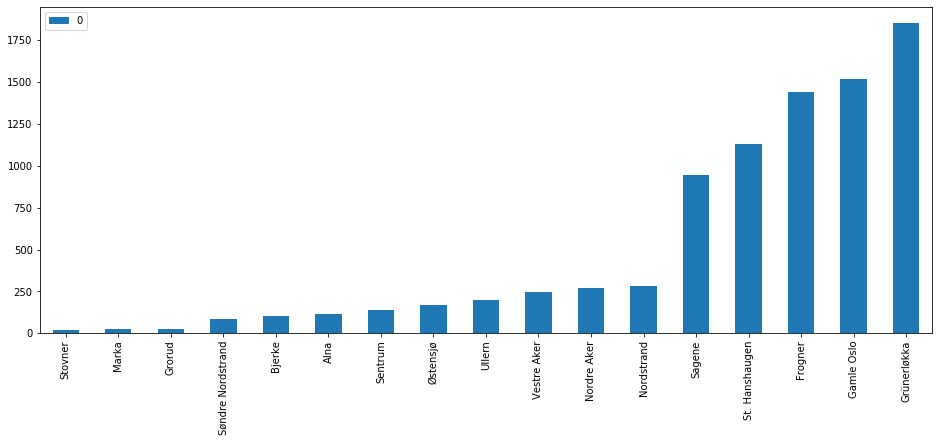

In [9]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
# muutetaan leveys
plt.rcParams["figure.figsize"] = [16, 6]
tdf.plot(kind='bar')

In [10]:
#df_nb = pd.DataFrame(nb_counts)
nb_counts
#len(nb_counts)

Counter({'Frogner': 1440,
         'Sagene': 944,
         'Gamle Oslo': 1518,
         'St. Hanshaugen': 1129,
         'Grünerløkka': 1856,
         'Nordstrand': 283,
         'Vestre Aker': 248,
         'Nordre Aker': 273,
         'Ullern': 198,
         'Østensjø': 170,
         'Søndre Nordstrand': 85,
         'Sentrum': 142,
         'Alna': 115,
         'Bjerke': 106,
         'Marka': 24,
         'Stovner': 20,
         'Grorud': 26})

In [11]:
#!pip install --upgrade pandas chek due azure
pd.__version__
#list(nb_counts)

'0.25.1'

Sama järjestely dataframen avulla. 

In [12]:
df_nb = pd.DataFrame.from_dict(nb_counts, orient='index', columns=['count'])
df_nb.columns
df_nb.sort_values(by=['count'], ascending=False)

,count
Grünerløkka,1856
Gamle Oslo,1518
Frogner,1440
St. Hanshaugen,1129
Sagene,944
Nordstrand,283
Nordre Aker,273
Vestre Aker,248
Ullern,198
Østensjø,170


Valitaan tarkasteluun 8 suosituinta 

In [13]:
df.price.value_counts()
top_neighbourhoods = df_nb.sort_values(by=('count'),ascending=False).head(8).index
top_neighbourhoods

Index(['Grünerløkka', 'Gamle Oslo', 'Frogner', 'St. Hanshaugen', 'Sagene',
       'Nordstrand', 'Nordre Aker', 'Vestre Aker'],
      dtype='object')

In [14]:
df.neighbourhood_cleansed.isin(top_neighbourhoods)

0       True
1       True
2       True
3       True
4       True
        ... 
8572    True
8573    True
8574    True
8575    True
8576    True
Name: neighbourhood_cleansed, Length: 8577, dtype: bool

In [15]:
df_short = df[df.neighbourhood_cleansed.isin(top_neighbourhoods)]
df_short.head()

,Unnamed: 0,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,0,Frogner,Entire home/apt,3,2.0,3.0,1925.0,28,37,97.0,t,moderate,0.50
1,1,Frogner,Private room,3,1.0,1.0,381.0,0,36,97.0,t,strict_14_with_grace_period,0.70
2,2,Frogner,Private room,1,1.0,2.0,472.0,0,47,96.0,f,strict_14_with_grace_period,0.44
3,3,Sagene,Entire home/apt,3,1.0,1.0,999.0,28,7,94.0,f,moderate,0.07
4,4,Gamle Oslo,Private room,3,1.0,2.0,499.0,0,48,95.0,f,moderate,0.46


Tutkitaan hintaa ja havaitaan kohtuu jyrkkä hinnannousu kalleimmassa osassa.

In [16]:
df.sort_values(by=['price'], ascending=False).head(20)

,Unnamed: 0,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
3501,3501,Nordstrand,Entire home/apt,5,3.0,3.0,90806.0,29,0,NaN,f,flexible,NaN
968,968,St. Hanshaugen,Private room,2,1.0,2.0,80000.0,29,69,99.0,f,strict_14_with_grace_period,1.38
4203,4203,Sentrum,Entire home/apt,4,2.0,2.0,69721.0,0,2,100.0,f,flexible,0.74
5544,5544,Frogner,Entire home/apt,8,4.0,6.0,30002.0,30,0,NaN,f,flexible,NaN
6950,6950,Sagene,Entire home/apt,4,2.0,4.0,17371.0,30,0,NaN,t,moderate,NaN
4015,4015,Gamle Oslo,Entire home/apt,6,3.0,3.0,15001.0,27,3,100.0,t,strict_14_with_grace_period,0.12
13,13,Sagene,Entire home/apt,6,2.0,2.0,14520.0,29,36,97.0,t,moderate,0.36
3620,3620,Vestre Aker,Entire home/apt,16,8.0,16.0,11995.0,29,3,100.0,f,strict_14_with_grace_period,0.10
3538,3538,Nordre Aker,Private room,2,0.0,1.0,10007.0,29,0,NaN,t,flexible,NaN
6600,6600,Sagene,Entire home/apt,1,0.0,3.0,9998.0,28,0,NaN,t,flexible,NaN


Poistetaan yli 14 000 hintaiset asunnot, ja tutkitaan hintarakennetta. 

In [17]:
df_short = df_short[df_short.price <= 14000]
df_short.price.describe()

count     7685.000000
mean       894.304880
std        656.371793
min         82.000000
25%        545.000000
50%        754.000000
75%        999.000000
max      11995.000000
Name: price, dtype: float64

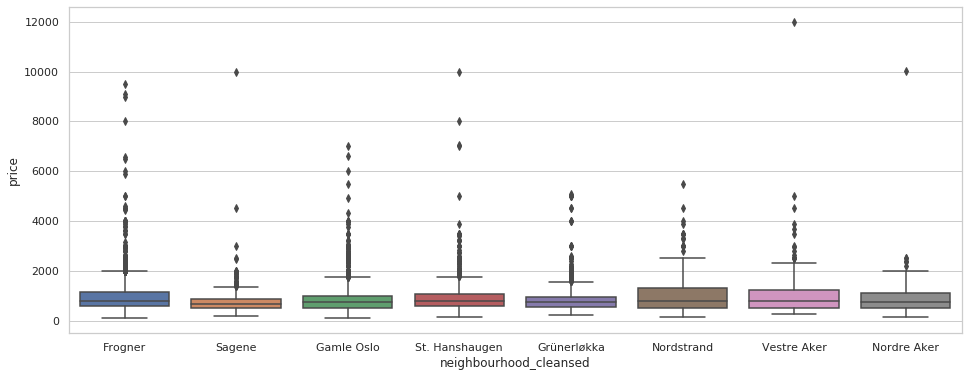

In [18]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x='neighbourhood_cleansed', y='price', data=df_short,)

Siivotaan, 'number_reviews' ja 'reviews_per_month' poistetaan 'NaN' arvot. Korvataan puuttuvat arvot 'reviews_per_month' nollalla 0 jossa oli alunperin NaN. 

Poistetaan rivit joissa makuuhuoneiden määrä on nolla

In [19]:
df.sort_values(by=['price'], ascending=False).head(20)

,Unnamed: 0,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
3501,3501,Nordstrand,Entire home/apt,5,3.0,3.0,90806.0,29,0,NaN,f,flexible,NaN
968,968,St. Hanshaugen,Private room,2,1.0,2.0,80000.0,29,69,99.0,f,strict_14_with_grace_period,1.38
4203,4203,Sentrum,Entire home/apt,4,2.0,2.0,69721.0,0,2,100.0,f,flexible,0.74
5544,5544,Frogner,Entire home/apt,8,4.0,6.0,30002.0,30,0,NaN,f,flexible,NaN
6950,6950,Sagene,Entire home/apt,4,2.0,4.0,17371.0,30,0,NaN,t,moderate,NaN
4015,4015,Gamle Oslo,Entire home/apt,6,3.0,3.0,15001.0,27,3,100.0,t,strict_14_with_grace_period,0.12
13,13,Sagene,Entire home/apt,6,2.0,2.0,14520.0,29,36,97.0,t,moderate,0.36
3620,3620,Vestre Aker,Entire home/apt,16,8.0,16.0,11995.0,29,3,100.0,f,strict_14_with_grace_period,0.10
3538,3538,Nordre Aker,Private room,2,0.0,1.0,10007.0,29,0,NaN,t,flexible,NaN
6600,6600,Sagene,Entire home/apt,1,0.0,3.0,9998.0,28,0,NaN,t,flexible,NaN


In [20]:
df.tail(5)

,Unnamed: 0,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
8572,8572,Frogner,Entire home/apt,3,NaN,1.0,1816.0,23,0,NaN,f,flexible,NaN
8573,8573,Nordre Aker,Entire home/apt,2,1.0,1.0,454.0,21,0,NaN,f,flexible,NaN
8574,8574,Frogner,Entire home/apt,2,1.0,1.0,953.0,24,0,NaN,f,flexible,NaN
8575,8575,Gamle Oslo,Entire home/apt,3,2.0,0.0,291.0,17,0,NaN,f,flexible,NaN
8576,8576,Grünerløkka,Entire home/apt,3,2.0,2.0,953.0,22,0,NaN,f,flexible,NaN


In [21]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == False)].index)

0

In [22]:
# the number of entries with at least 1 'number_of_reviews' which have a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [23]:
# so we need to do some cleaning.

# first fixup 'reviews_per_month' where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# just drop rows with bad/weird values
# (we could do more here)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

6108

Otetaan vain huoneet joissa on 1 makuuhuone.

In [24]:
df = df[df.bedrooms == 1]
len(df.index)

3861

In [25]:
df.price.head(5)

1    381.0
2    472.0
3    999.0
4    499.0
7    745.0
Name: price, dtype: float64

Muutetaan hinta, tosin muunnos tehtiin jo aiemmin, vaihdetaan $ merkki tyhjään ja muutetaan tyypiksi ja tulostetaan 100 suurinta arvoa. ensin kalleimmat.

In [26]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.sort_values(ascending=False).head(100)

968     80000.0
4276     9998.0
1250     9998.0
6658     7001.0
194      7001.0
         ...   
2919     1498.0
7580     1498.0
3517     1498.0
2747     1498.0
6550     1489.0
Name: price, Length: 100, dtype: float64

Halvimmat hinnat

In [27]:
df.price.sort_values(ascending=True).head(30)

6295    154.0
4756    154.0
6969    173.0
3060    173.0
4773    182.0
8389    182.0
2988    182.0
397     182.0
7962    182.0
3117    191.0
3162    191.0
6737    200.0
4786    200.0
1699    200.0
2896    200.0
198     200.0
7721    200.0
4661    200.0
4114    200.0
3332    209.0
3712    209.0
4601    209.0
5453    218.0
703     218.0
8255    218.0
5298    218.0
1862    218.0
8201    218.0
6961    227.0
4859    227.0
Name: price, dtype: float64

Suosituimmat hinnat

In [28]:
df.price.value_counts()

499.0     285
599.0     260
699.0     207
799.0     192
400.0     158
         ... 
1180.0      1
1072.0      1
2034.0      1
6602.0      1
1671.0      1
Name: price, Length: 163, dtype: int64

Jokaiselle alueelle tehdään oma sarake. Jokaiselle kaupungin osalle tehdään oma sarake jossa on 1 jos asunto sijaitsee ko. kaupunginosassa muuten arvo on nolla. sama tehdään myös huone tyypille ja perutus tavalle. Poistetaan alkuperäiset sarakkeet ja dummy muuttujat liitetään osaksi data framea.

In [29]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,Unnamed: 0,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Alna,...,Østensjø,Entire home/apt,Hotel room,Private room,Shared room,flexible,moderate,strict_14_with_grace_period,super_strict_30,instant_t
1,1,3,1.0,1.0,381.0,0,36,97.0,0.70,0,...,0,0,0,1,0,0,0,1,0,1
2,2,1,1.0,2.0,472.0,0,47,96.0,0.44,0,...,0,0,0,1,0,0,0,1,0,0
3,3,3,1.0,1.0,999.0,28,7,94.0,0.07,0,...,0,1,0,0,0,0,1,0,0,0
4,4,3,1.0,2.0,499.0,0,48,95.0,0.46,0,...,0,0,0,1,0,0,1,0,0,0
7,7,2,1.0,1.0,745.0,0,10,98.0,0.22,0,...,0,1,0,0,0,0,0,1,0,0


Sarakkeiden lukumäärä

In [30]:
len(allcols)

35

Tulostetaan dataframen sarakkeet

In [31]:
pd.Series(allcols).head(35)

0                      Unnamed: 0
1                    accommodates
2                        bedrooms
3                            beds
4                           price
5                 availability_30
6               number_of_reviews
7            review_scores_rating
8               reviews_per_month
9                            Alna
10                         Bjerke
11                        Frogner
12                     Gamle Oslo
13                         Grorud
14                    Grünerløkka
15                          Marka
16                    Nordre Aker
17                     Nordstrand
18                         Sagene
19                        Sentrum
20                 St. Hanshaugen
21                        Stovner
22              Søndre Nordstrand
23                         Ullern
24                    Vestre Aker
25                       Østensjø
26                Entire home/apt
27                     Hotel room
28                   Private room
29            

Otetaan hajonta piste kaavioon```scatter_matrix``` Pandas funktiolla kentät joissa on kiinnostavia tietoja.

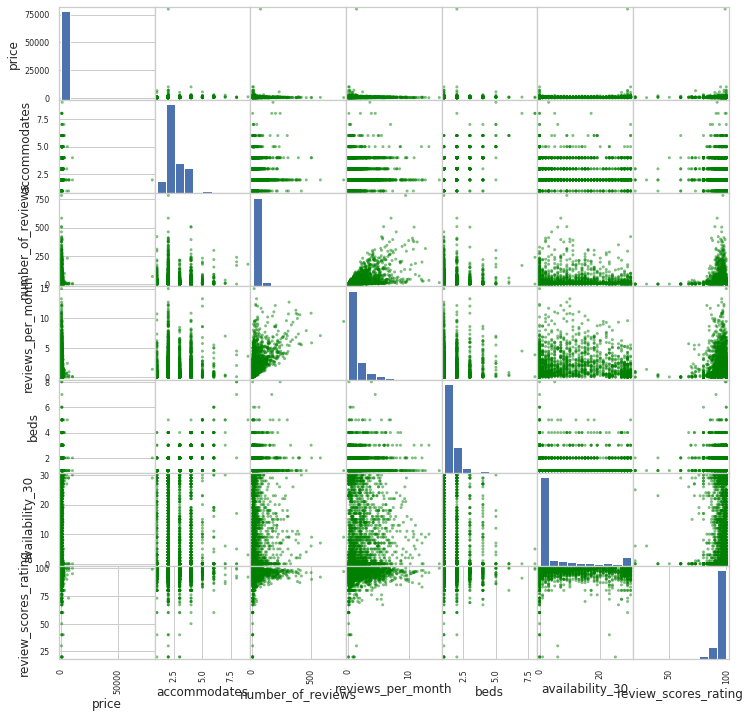

In [32]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.plotting.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='green')

Tarkastellaan ```scatter_matrix```, jos arvioita on vähä vaihtelu on suurta. 

### Koneoppiminen Scikit-Learn and Spark avulla
lineaarinen refgressio, ridge, lasso, Elastic Net, Bayers ridge, OMP
pienin ja suurin virhe 160


Text(0, 0.5, 'Median Absolute Error')

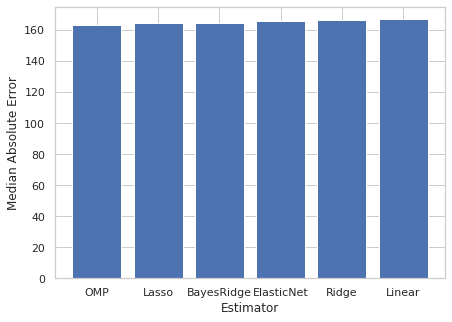

In [33]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Parannetaam mallia

In [34]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

sorted(sklearn.metrics.SCORERS.keys())

The scikit-learn version is 0.21.3.


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

Valitaan neg_mean_absolute_error

In [40]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.02 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.02, loss='lad', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
abs(clf.best_score_)


116.79062639784196

keskimääräinen virhe $117.41.

Already, it looks like we're doing better with GradientBoostingRegressor than we were with any of the prior attempts. Without doing any tuning, the median error is around 20% less than the best error of the previous group (with BayesRidge()).

Let's get a quick measure of how the error is affected by each round of boosting, so we can see if throwing more iterations at the problem is going to help.

Text(0, 0.5, 'Least Absolute Deviation')

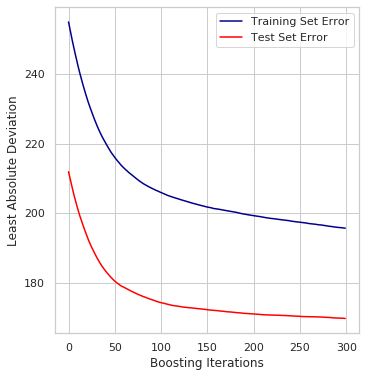

In [42]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Ominaisuuden merkitykset

It looks like the curve is flattening near the right side of the plot (after around 200-250 iterations), but is still benefitting from more iterations, so we could increase the iterations to 500 without much thought.

Now we can do some tuning with GridSearchCV and explore more of the hyperparameter combinations. However, this requires some serious CPU and a complete run of all of the combinations can easily take hours to finish, even on a small number of rows.

By simply replacing the following lines in our file, we can use the new spark-sklearn integration package running on the [MapR 5.1 platform with Spark as a YARN client](http://maprdocs.mapr.com/51/index.html#Spark/SparkonYARN.html) to distribute the iterations across the machines in a cluster. This allows us to test more hyperparameter combinations, ultimately reducing error, and we can do it all in less time.

```
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV

conf = SparkConf()
sc = SparkContext(conf=conf)
clf = GridSearchCV(sc, gbr, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')
```

You can then run the script in this notebook with the following command, setting --num-executors and --executor-cores to suit your Spark environment:

```
time MASTER=yarn-client /opt/mapr/spark/spark-1.5.2/bin/spark-submit --num-executors=2 --executor-cores=8 python_scikit_airbnb.py
```

It's worth pausing here to note that the architecture of this approach is different than that used by MLlib in Spark. Using spark-sklearn, we're simply distributing the cross-validation run of each model (with a specific combination of hyperparameters) across each Spark executor. Spark MLlib, on the other hand, will distribute the internals of the actual learning algorithms across the cluster.
The main advantage of spark-sklearn is that it enables leveraging the very rich set of machine learning algorithms in scikit-learn. These algorithms do not run natively on a cluster (although they can be parallelized on a single machine) and by adding Spark, we can unlock a lot more horsepower than could ordinarily be used.

**Using this approach we can get the error down even further, to $21.43**, with a substantial reduction in time.

Ominaisuuksia vaikutus, mikä vaikuttaa eniten. 

Text(0.5, 1.0, 'Variable Importance')

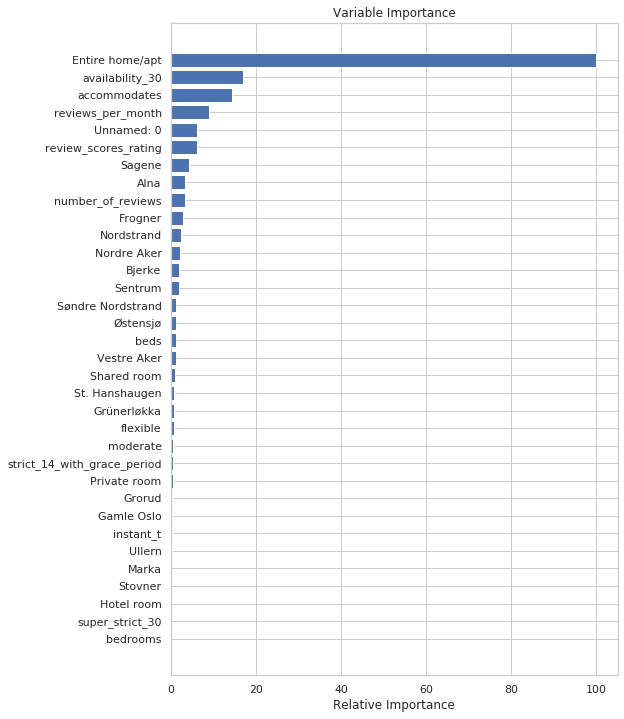

In [38]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

### Conclusions

In this example we looked at how to predict the price using multiple factors, then scale-out our cross validation and hyperparameter search across a MapR cluster using Spark. We learned the following key points:

* In this case, the ensemble method we tried (GradientBoostingRegressor) had better results than any individual estimator.

* With GridSearchCV, we tested more hyperparameter combinations that ultimately led us to a better result.

* Using [spark-sklearn](https://github.com/databricks/spark-sklearn) is a straightforward way to throw more CPU at any machine learning problem you might have.  We used the package to reduce the time spent searching and reduce the error for our estimator.

There are many ways in which our first-pass analysis could be improved.  For example, we might start including more of the data from Inside Airbnb.  We could do sentiment analysis on the text of the reviews, bringing this in as an additional feature.

A quick way to try the example code here on your own is with the [MapR Sandbox](https://www.mapr.com/products/mapr-sandbox-hadoop/tutorials/spark-tutorial), which comes pre-installed with MapR-FS and Spark.

In the next post in the series we'll look at how to to apply the same technique to building a classifier.


Regular expression esimerkki

In [39]:
import re

str = "Sataa Tampereella"
x= re.sub("aa","oi",str)

print(x)

Satoi Tampereella
